In [1]:
# Link to Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from glob import glob
os.chdir('./drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Coastline_parcels_polygon')
os.getcwd()

'/content/drive/MyDrive/THESIS_AQUAPONDS/ROI/Aquaculture_Asia_Coast_2019/Coastline_parcels_polygon'

In [3]:
# Install packages
!pip install shapely
!pip install geopandas
import shapely as shp
#from shapely.geometry import Multipolygon
import geopandas as gpd
import numpy as np
#import json

In [4]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=OtTYhAouGgcBBKEqwDBhwQetj-z0sEagXRqXd_4hopA&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjy1Xe1uOKgA77-ensC4RGsSbtjcxMKiItmfbBS8w81YRyW-9TWVXw

Successfully saved authorization token.


## User-defined Functions

In [5]:
# Get border coords as input to GEE, Using list comprehension
def getBorder(polygon):
  x,y = polygon.exterior.coords.xy
  border = [[lon, lat] for lon, lat in zip(x,y)]
  return border

# Usual For-loop
#border = []
#for i in range(len(roi_merged)):
#  x,y = roi_merged[i].exterior.coords.xy
#  border.append([[lon,lat] for lon, lat in zip(x,y)])
#border[1]

In [6]:
# Function to Mask Clouds
def maskCloud(image):
  cloudMask = image.select(['pixel_qa']).bitwiseAnd(1<<5).eq(0)
  cloudShadowMask = image.select(['pixel_qa']).bitwiseAnd(1<<3).eq(0)
  final_mask = cloudMask.And(cloudShadowMask)
  return image.updateMask(final_mask)

In [7]:
# Function for Smoothing
def smooth(image):
  kernel = ee.Kernel.square(radius = 7, units = 'pixels', normalize = True)
  return image.convolve(kernel)

In [8]:
# Function of ostu's method
def otsu(histogram):
    counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
    means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
    size = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean = sum.divide(total)

    indices = ee.List.sequence(1, size)

    def iFunc(i):
      aCounts = counts.slice(0, 0, i) 
      aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
      aMeans = means.slice(0, 0, i)
      aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(),[0]).get([0]).divide(aCount)
      bCount = total.subtract(aCount)
      bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount)
      return aCount.multiply(aMean.subtract(mean).pow(2)) \
            .add(bCount.multiply(bMean.subtract(mean).pow(2)))

    # Compute between sum of squares, where each mean partitions the data
    bss = indices.map(iFunc)

    return means.sort(bss).get([-1])

In [41]:
# Function of Otsu's Method
def thresholding(image):

  #Compute the histogram of the NIR band. (the mean and variance are only FYI)
  histogram = image.select(['B4']).reduceRegion(
      reducer = ee.Reducer.histogram(255,2).combine('mean', None, True).combine('variance', None, True),
      geometry = roi.getInfo(),
      scale = 30,
      bestEffort = True)
  
  threshold = otsu(histogram.get('B4_histogram'))
  water = image.select(['B4']).lt(threshold)
  return water.rename(['watermask']) \
              .clip(roi) \
              .copyProperties(image) \
              .set('system:time_start', ee.Date.fromYMD(image.get('year'), 12, 31))

In [ ]:
# Maybe Hint? https://gis.stackexchange.com/questions/302760/gee-imagecollection-map-with-multiple-input-function/302778

# Nested Function "thresholding"
def thresholding2(image, roi):
  var wrap = lambda

In [10]:
# Function to have difference between two years
def annual_diff(list):
  diff = ee.Image(ee.List(list).get(1)).subtract(
      ee.Image(ee.List(list).get(0))
  )
  return diff.set({'year': ee.Image(ee.List(list).get(1)).get('year'),
                   'system:time_start': ee.Image(ee.List(list).get(1)).get('system:time_start')})

In [11]:
# Function for remapping
def remap_gain(image):
  gain = image.eq(1).selfMask()
  return gain.remap([1], ee.List([image.get('year')])) \
             .rename('gain_year') \
             .copyProperties(image)

In [12]:
# Function for unite pixel type
def unipt(image):
  return image.cast({'gain_year': ee.PixelType('int', 1984, 2019)})             

In [13]:
# Function to Visualize
import folium

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'
print('Folium version: ' + folium.__version__)


# Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

Folium version: 0.8.3


## Prepare ROI (Asia) for processing

In [14]:
# Load ROI
roi_path = glob(os.path.join(os.getcwd(), '*.gpkg'))
#print(roi_path)

asia = gpd.read_file(roi_path[0])

# Reproject to 4326
asia = asia.to_crs(4326)
print(asia.crs)

epsg:4326


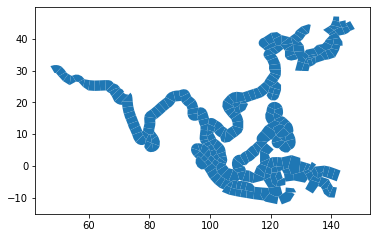

In [15]:
asia.plot()

In [16]:
asia_multipoly = asia['geometry']

# Make a list of polygons out of twice nested multipolygons
asia_poly = [list(i) for i in asia_multipoly]
# Flatten the list
asia_poly = [item for sublist in asia_poly for item in sublist]
asia_poly[:5]

In [17]:
borders = [getBorder(i) for i in asia_poly]
len(borders)

261

In [18]:
#ROI = ee.Geometry.MultiPolygon(coords = borders)

## Start Precessing in GEE (roi:Asia)

## Wrapped-up to Function

In [42]:
def annualGain(border):

  # Define ROI
  roi = ee.Geometry.MultiPolygon(coords = border)

  # Load Satellitie Archive
  ls7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR") \
        .filterDate('1999', '2020') \
        .filterBounds(roi).sort("system:time_start", True)
  ls5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR") \
        .filterDate('1984', '2013') \
        .filterBounds(roi).sort("system:time_start", True)
  ls4 = ee.ImageCollection("LANDSAT/LT04/C01/T1_SR") \
        .filterDate('1984', '1994') \
        .filterBounds(roi).sort("system:time_start", True)
  ls_all = ls7.merge(ls5).merge(ls4) \
          .sort('system:time_start', True) \
          .map(maskCloud) \
          .map(smooth)

  # Reduce ImageCollection, Group by YEAR
  years = ee.List.sequence(1984, 2019)
  ls_Treduced = ee.ImageCollection.fromImages(
      years.map(lambda YEAR: ls_all.filter(ee.Filter.calendarRange(YEAR, YEAR, 'year')) \
                .mean().clip(roi).set({'year': YEAR, 'system:time_start': ee.Date.fromYMD(YEAR, 12, 31)})))
  
  # Add "bandlength" as new property
  ls_Treduced = ls_Treduced.map(lambda image: image.set('bandlength', image.bandNames().size()))
  # Filter out the years where no data are available
  ls_Treduced = ls_Treduced.filterMetadata('bandlength', 'not_equals', 0)

  # Water Mask with Otsu's Method
  ls_wmsk = ls_Treduced.map(thresholding)
  #ls_wmsk = thresholding(image = ls_Treduced, roi = roi)

  # Yearly Step (Iteration)
  list_wmsk = ls_wmsk.toList(ls_wmsk.size())
    # Calculate "Backward Gradient", i.e. (Tn+1 - Tn)
  ls_grad = list_wmsk.slice(0) \
            .zip(list_wmsk.slice(1)) \
            .map(annual_diff)
  ls_84 = ee.List([ls_wmsk.first()])
  list_footprint = ls_84.cat(ls_grad) 
  ls_footprint = ee.ImageCollection.fromImages(list_footprint) 

  # Remap value "1" (ponds gain) to "year" of that gain
  ls_gain = ls_footprint.select(['watermask']).map(remap_gain).map(unipt)

  # Mosaic
  fishpond_Gain = ls_gain.mosaic().cast({'gain_year': ee.PixelType('int', 1984, 2019)})
  return fishpond_Gain

In [43]:
# Test Function using just a few parcels
test = [annualGain(border) for border in borders[:5]]
#test = [annualGain(i) for i in range(len(borders[:5]))]
len(test)

NameError: ignored

In [28]:
def func1(a,c):
  b = a + c
  return b

In [29]:
C = [[1], [1,2], [1,2,3]]
def func2(i):
  c = len(i)
  y = func1(2,c)
  return y

In [30]:
my_var = [func2(i) for i in C]
my_var

[3, 4, 5]